## Fitting data dari file .TXT (real data)



In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# import seaborn as sns; sns.set()

plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

# from astropy.visualization import astropy_mpl_style

# plt.style.use(astropy_mpl_style)

plt.rcParams['figure.figsize'] = (16,10)
plt.rcParams['font.size'] = 16

### Import data dari file txt:

In [3]:
from astropy.io import ascii

data = ascii.read('datatest.txt')

data.colnames

['period', 'mag']

Text(0,0.5,'$m$')

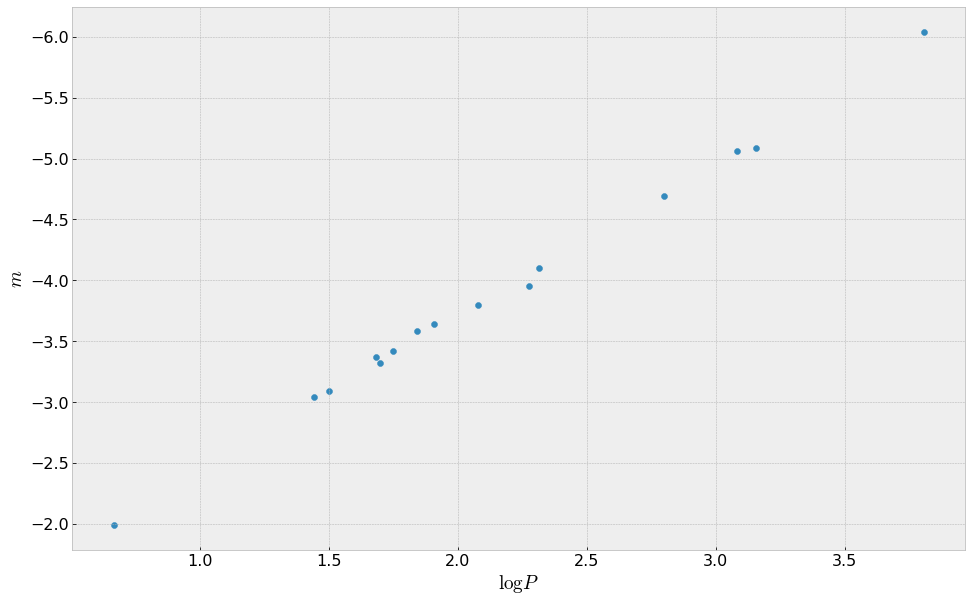

In [4]:
plt.scatter(np.log(data['period']), data['mag'])
plt.ylim(reversed(plt.ylim()))
plt.xlabel(r'$\log P$')
plt.ylabel(r'$m$')

### Menyatakan model:

In [5]:
datapoints = np.array([np.log(data['period']), data['mag']]) # ubah astropy.table ke array supaya bisa dinput ke model

datapoints[0]

array([0.66782937, 1.44456327, 1.49962305, 1.68268837, 1.69744879,
       1.74919985, 1.84054963, 1.9095425 , 2.07944154, 2.27726729,
       2.316488  , 2.79789091, 3.08328517, 3.15444396, 3.80621795])

In [6]:
from pymc3 import Model, Normal, HalfNormal

with Model() as model:
    # prior
    alpha = Normal('alpha', mu=0., sd=10.)
    beta = Normal('beta', mu=0., sd=10.)
    sigma = HalfNormal('sigma', sd=1.)
    
    #expected outcomes
    mu = alpha + beta*datapoints[0]
    
    # likelihood
    y_obs = Normal('y_obs', mu=mu, sd=sigma, observed=datapoints[1])
    

C:\Users\pj\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Analisis posterior

In [7]:
from pymc3 import find_MAP

map_estimate = find_MAP(model=model)

map_estimate

logp = 16.688, ||grad|| = 183.3: 100%|███████████████████████████████████████████████| 28/28 [00:00<00:00, 2803.55it/s]


{'alpha': array(-1.20527607),
 'beta': array(-1.25289726),
 'sigma_log__': array(-3.02940044),
 'sigma': array(0.04834461)}

In [8]:
from pymc3 import NUTS, sample

with model:
    start = find_MAP()
    
    step = NUTS(scaling=start)
    
    trace = sample(2500, step, start=start, tune=500)

logp = 16.688, ||grad|| = 183.3: 100%|███████████████████████████████████████████████| 28/28 [00:00<00:00, 2800.27it/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, beta, alpha]
The number of effective samples is smaller than 25% for some parameters.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C83CA35F28>,
      dtype=object)

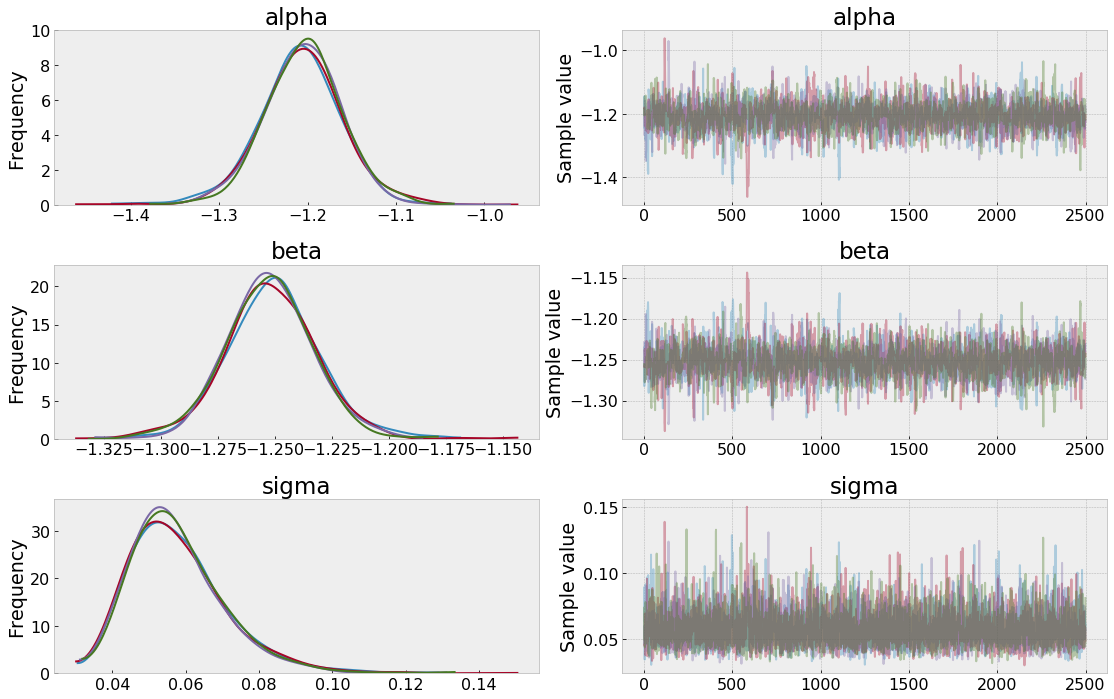

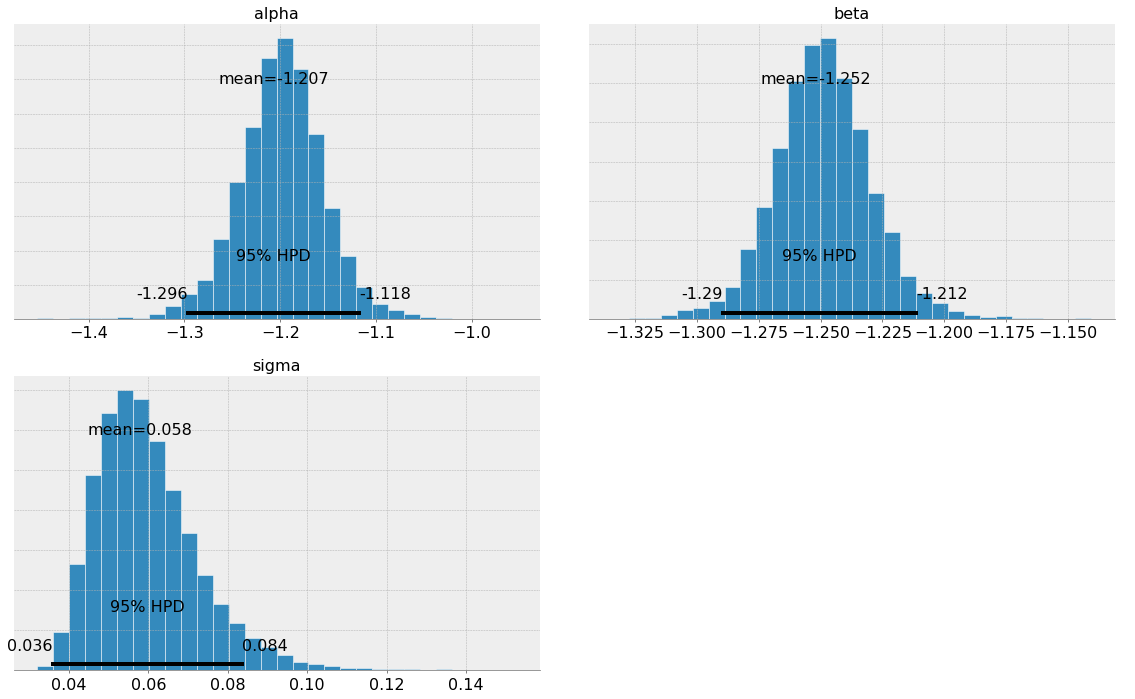

In [9]:
from pymc3 import traceplot

traceplot(trace, figsize=(16,10))

from pymc3 import plot_posterior

plot_posterior(trace, figsize=(16,10))

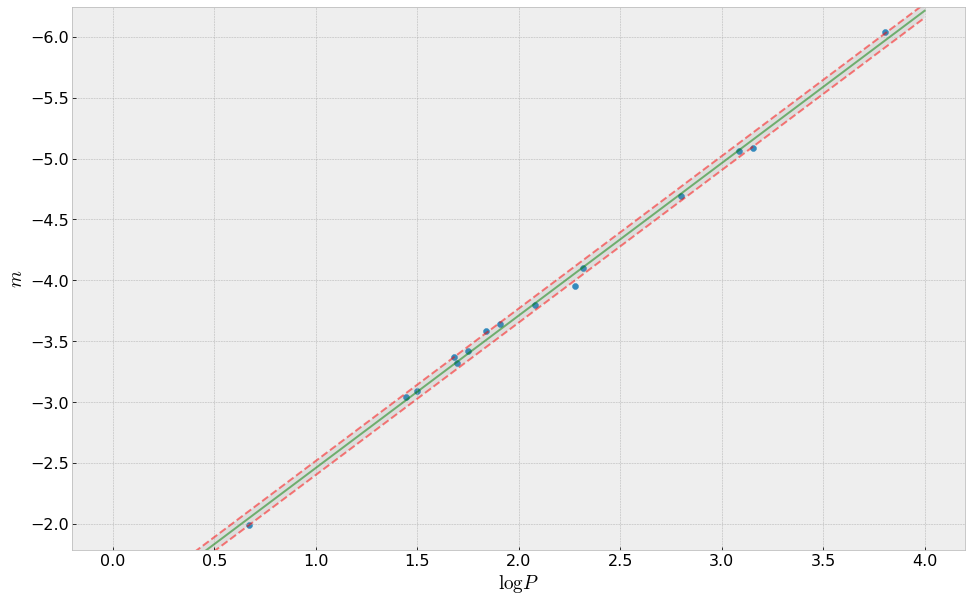

In [10]:
ax = plt.subplot()

x = np.linspace(0, 4, 8000)

y = np.mean(trace['alpha']) + np.mean(trace['beta'])*x

y1 = y - np.mean(trace['sigma'])
y2 = y + np.mean(trace['sigma'])

plt.scatter(datapoints[0], datapoints[1])
plt.ylim(reversed(plt.ylim()))

ax.plot(x, y, '-g', alpha=0.5)

ax.plot(x, y1, '--r', alpha=0.5)
ax.plot(x, y2, '--r', alpha=0.5)

plt.xlabel('$\log P$')
plt.ylabel('$m$')

plt.fill_between(x, y1, y2, facecolor='gray', alpha=0.15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C83CFEECF8>,
      dtype=object)

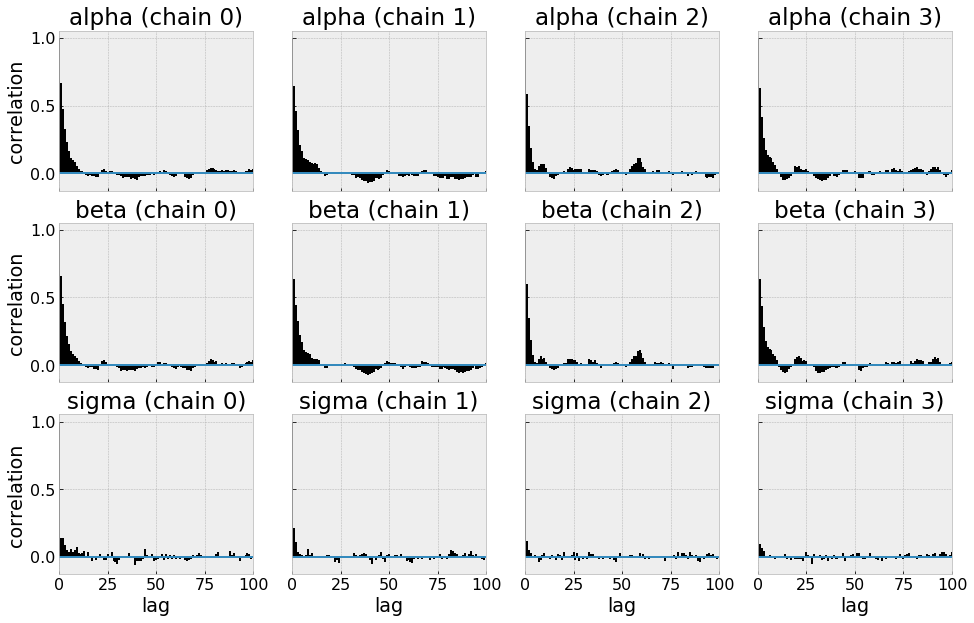

In [11]:
from pymc3 import autocorrplot

autocorrplot(trace, figsize=(16,10))

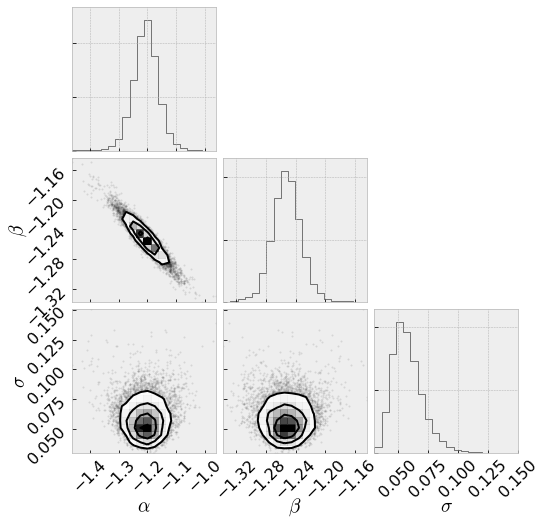

In [12]:
import corner
import pandas as pd

# ubah trace menjadi pandas data frame supaya bisa dibuatkan corner plot
data = np.column_stack((trace['alpha'], trace['beta'], trace['sigma'])) 

pairplot = pd.DataFrame(data, columns=[r'$\alpha$',r'$\beta$',r'$\sigma$'])

fig = corner.corner(pairplot)